In [2]:
import datetime as dt
import pandas as pd
from matplotlib import pyplot as plt
import utils
from scipy.optimize import minimize
import numpy as np

## Reading in Data

In [3]:
# Reading in the dataframe and converting to dates and floats
btc_df = pd.read_csv("Data.csv", index_col=0, parse_dates=True)
btc_df["price"] = btc_df["price"].str.replace(",", "").astype(float)
btc_df["price_diff"] = btc_df["price"] - btc_df["price"].shift(1)
btc_ar = btc_df.values

# Verifying that no days are missing in the model
assert all(btc_df.index.to_series() == pd.date_range(start="2020-04-25", end="2025-10-15"))

In [4]:
def get_df():
    # A function that returns the bitcoin dataframe
    btc_df = pd.read_csv("Data.csv", index_col=0, parse_dates=True)
    btc_df["price"] = btc_df["price"].str.replace(",", "").astype(float)
    btc_df["price_diff"] = btc_df["price"] - btc_df["price"].shift(1)
    return btc_df

## First Autoregressive Model Experiment

Here we'll try to model the future price based on two days; one from a week ago and one from a month ago.

In [5]:
def build_guess_column(params, df, shifts, col_name="price", est_name="estimation_column"):
    """
    Adds a new column to the input dataframe that builds the estimated values out of linear transformations of shifted columns.
    """
    df = df.copy()
    df[est_name] = sum([params[i] * df[col_name].shift(shift) for i, shift in enumerate(shifts)])
    return df

In [6]:
def compute_loss(params, df, shifts, col_name="price", est_name="estimation_column"):
    """
    Computes the loss for a guess. Uses mean-squares as the loss function.
    """
    est_df = build_guess_column(params, df, shifts, col_name=col_name, est_name=est_name)
    diff = (est_df[col_name] - est_df[est_name])**2
    return diff.sum()

Optimal exposures: [ 0.94936922  0.06627886  0.00504538 -0.00223336  0.01045524 -0.02552327
 -0.01487363 -0.04742145  0.09913483 -0.02169876  0.00595487 -0.06619649
  0.08707169 -0.02786847 -0.03838983 -0.0040929   0.03901699 -0.02885578
 -0.02289407  0.02440206  0.01040179 -0.00232177 -0.03107474  0.08208754
 -0.0010144  -0.02101166  0.0364133   0.00309735 -0.08571681  0.02238985]
Optimal loss:      2583529487.1844454


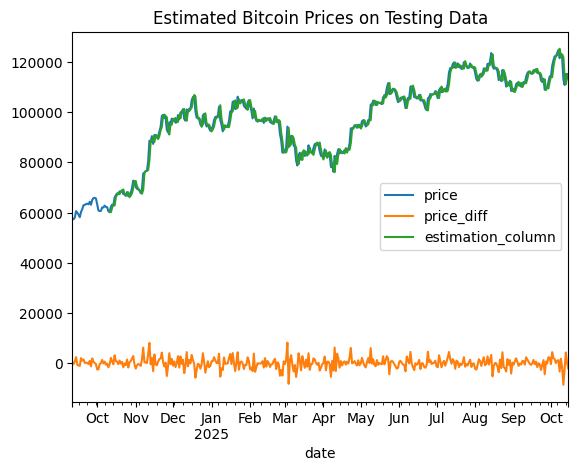

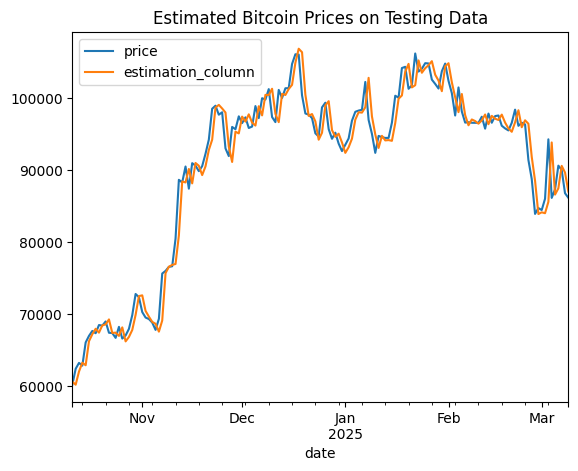

In [36]:
# Making a train-test split
n = len(btc_df)
btc_df_train, btc_df_test = btc_df.iloc[:int(0.8*n)], btc_df.iloc[int(0.8*n):]

# Training the coefficients
shifts = list(range(1, 31, 1))
x0 = [1 for _ in range(len(shifts))]
result = minimize(compute_loss, x0, args=(btc_df_train, shifts))

print(f"Optimal exposures: {result.x}")
print(f"Optimal loss:      {result.fun}")

# Graphing the daily guesses
params = result.x

est_df = build_guess_column(params, btc_df_test, shifts)
est_df.plot()
plt.title("Estimated Bitcoin Prices on Testing Data")
plt.show()

est_df.iloc[max(shifts):max(shifts) + 150][["price", "estimation_column"]].plot()
plt.title("Estimated Bitcoin Prices on Testing Data")
plt.savefig("Pictures/autoregressive_price_estimation.png", dpi=300, bbox_inches="tight")
plt.show()

## Experimenting on daily returns instead of daily prices

Optimal exposures: [-4.51349190e-02  1.83138847e-02  2.54251074e-02  1.93426964e-02
  2.36582152e-02  1.37493846e-05 -1.33607390e-02 -6.23991195e-02
  3.44871993e-02  1.70670321e-02  2.85151845e-02 -4.38363048e-02
  4.69122612e-02  2.18084813e-02 -1.60988242e-02 -2.87021090e-02
  1.43880991e-02 -1.52794322e-02 -3.78768162e-02]
Optimal loss:      2620351686.80933


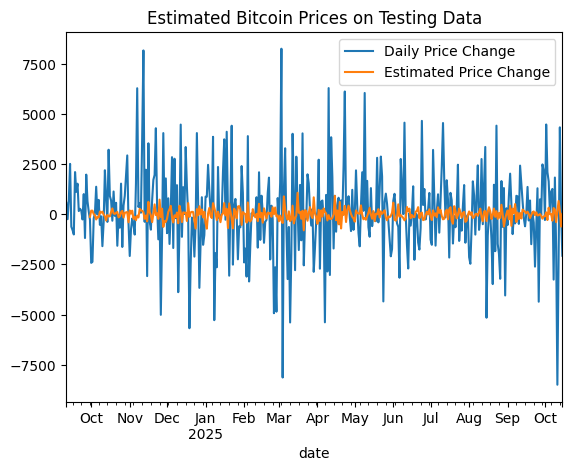

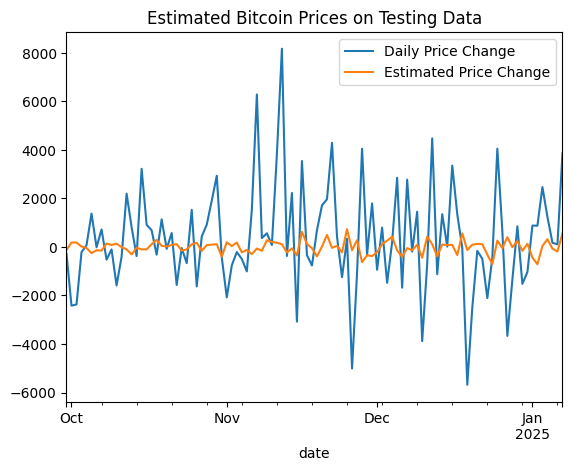

In [41]:
# Making a returns df
ret_df = get_df()
ret_df.drop(columns="price", inplace=True)

# Making a train-test split
n = len(ret_df)
ret_df_train, ret_df_test = ret_df.iloc[:int(0.8*n)], ret_df.iloc[int(0.8*n):]

# Training the coefficients
shifts = list(range(1, 20, 1))
x0 = [1 for _ in range(len(shifts))]
result = minimize(compute_loss, x0, args=(ret_df_train, shifts, "price_diff", "est_price_diff"))

print(f"Optimal exposures: {result.x}")
print(f"Optimal loss:      {result.fun}")

# Graphing the daily guesses
params = result.x

est_df = build_guess_column(params, ret_df_test, shifts, "price_diff", "est_price_diff")
est_df.plot()
plt.title("Estimated Bitcoin Prices on Testing Data")
plt.legend(labels=["Daily Price Change", "Estimated Price Change"])
plt.show()

est_df.iloc[max(shifts):max(shifts) + 100].plot()
plt.title("Estimated Bitcoin Prices on Testing Data")
plt.legend(labels=["Daily Price Change", "Estimated Price Change"])
plt.savefig("Pictures/autoregressive_price_fail.png", dpi=300, bbox_inches="tight")
plt.show()

In [31]:
# It seems like this is overfit
print(f"Correct Classification Rate: ", end="")
print(sum(np.sign(est_df["price_diff"]) == np.sign(est_df["est_price_diff"])) / len(est_df["price_diff"]))

Correct Classification Rate: 0.5225
